202318046
Aditya Tripathi

In [ ]:
!pip install pyspark
!pip install ucimlrepo
import pandas as pd
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when, length, col, dayofweek, lit
from pyspark.sql.types import StringType, IntegerType, TimestampType, StructType, StructField

In [ ]:
from pyspark.ml import Pipeline
from ucimlrepo import fetch_ucirepo
from pyspark.sql import SparkSession
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Online News Popularity") \
    .getOrCreate()

In [ ]:
# Fetch dataset
df = fetch_ucirepo(id=332)

# Print metadata
print("Metadata:")
print(df.metadata)

# Print variable information
print("\nVariable Information:")
print(df.variables)

Metadata:
{'uci_id': 332, 'name': 'Online News Popularity', 'repository_url': 'https://archive.ics.uci.edu/dataset/332/online+news+popularity', 'data_url': 'https://archive.ics.uci.edu/static/public/332/data.csv', 'abstract': 'This dataset summarizes a heterogeneous set of features about articles published by Mashable in a period of two years. The goal is to predict the number of shares in social networks (popularity).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 39797, 'num_features': 58, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': [' shares'], 'index_col': ['url'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Thu Feb 15 2024', 'dataset_doi': '10.24432/C5NS3V', 'creators': ['Kelwin Fernandes', 'Pedro Vinagre', 'Paulo Cortez', 'Pedro Sernadela'], 'intro_paper': {'title': 'A Proactive Intelligent Decision Support System fo

In [ ]:
# Convert Pandas DataFrame to PySpark DataFrame
df_spark = spark.createDataFrame(pd.concat([df.data.features, df.data.targets], axis=1))

# Show the first few rows of the DataFrame
print(df_spark.show(5))

# Show schema
print(df_spark.printSchema())

#Show count
print(df_spark.count())

+---------------+-----------------+----------------+-----------------+-------------------------+----------+---------------+---------+-----------+---------------------+-------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+---------------------------+------------------+-------------------+---------------------+--------------------+------------------+--------------------+------------------+-----------+---------------+---------------+---------------+---------------+---------------+--------------------+--------------------------+---------------------------+---------------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------

In [ ]:
# Remove null values in rows
df_spark_drop_rows = df_spark.dropna(how='any')

# Remove null values in columns
df_spark_drop_cols = df_spark.dropna(how='any', subset=df_spark.columns)

# Show the first few rows of the cleaned DataFrame after removing null values in rows
df_spark_drop_rows.show()

# Count of rows after removing null values in rows
print("Count after removing null values in rows:", df_spark_drop_rows.count())

# Show the first few rows of the cleaned DataFrame after removing null values in columns
df_spark_drop_cols.show()

# Count of rows after removing null values in columns
print("Count after removing null values in columns:", df_spark_drop_cols.count())

+---------------+-----------------+----------------+-----------------+-------------------------+----------+---------------+---------+-----------+---------------------+-------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+---------------------------+------------------+-------------------+---------------------+--------------------+------------------+--------------------+------------------+-----------+---------------+---------------+---------------+---------------+---------------+--------------------+--------------------------+---------------------------+---------------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------

In [ ]:
# Set the threshold value
threshold = 1000

# Create a new column 'popularity' based on the binary outcome
df_spark = df_spark.withColumn("popularity", when(df_spark[" shares"] >= threshold, 1).otherwise(0))

# Show the first few rows of the DataFrame with the new binary target variable
df_spark.show(10)

+---------------+-----------------+----------------+-----------------+-------------------------+----------+---------------+---------+-----------+---------------------+-------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+---------------------------+------------------+-------------------+---------------------+--------------------+------------------+--------------------+------------------+-----------+---------------+---------------+---------------+---------------+---------------+--------------------+--------------------------+---------------------------+---------------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------

+-------+------------------+-----------------+------------------+-----------------+-------------------------+------------------+------------------+-----------------+------------------+---------------------+------------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+--------------------------+--------------------------+---------------------------+-------------------+-------------------+---------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------------+---------------------------+---------------------------+-----------

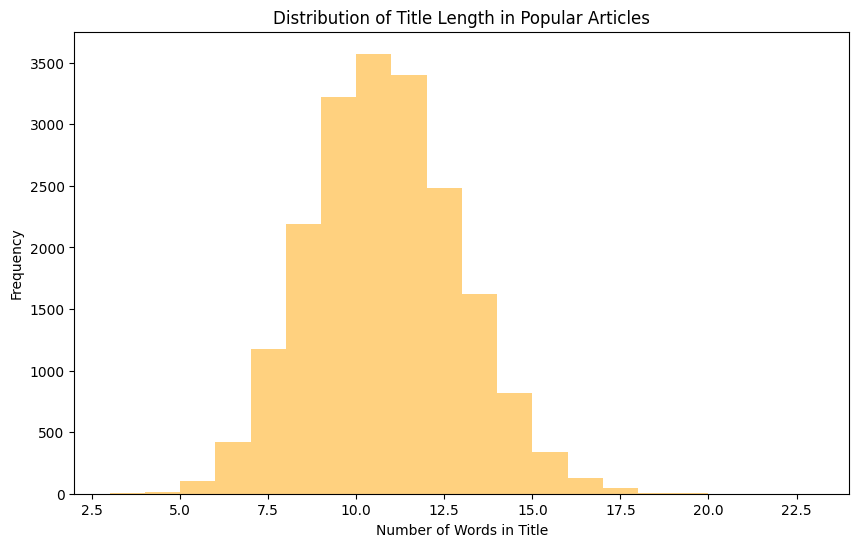

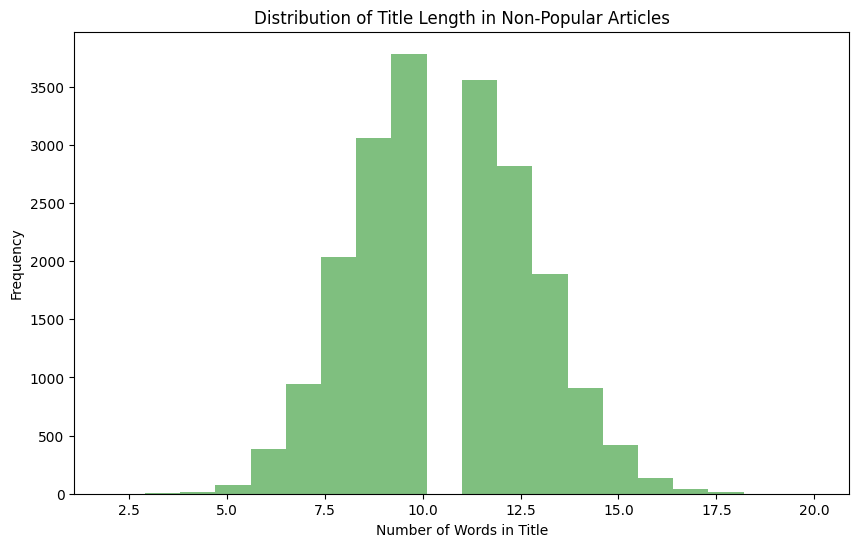

In [ ]:
import matplotlib.pyplot as plt
df_spark.describe().show()

# Identify the target variable
target_variable = ' shares'
# Explore characteristics of popular and non-popular articles
popular_articles = df_spark.filter(df_spark[target_variable] > df_spark.select(target_variable).approxQuantile(target_variable, [0.5], 0.01)[0])
non_popular_articles = df_spark.filter(df_spark[target_variable] <= df_spark.select(target_variable).approxQuantile(target_variable, [0.5], 0.01)[0])

# Example analysis: Comparing the number of words in the title between popular and non-popular articles
# Plotting histogram for popular articles
plt.figure(figsize=(10, 6))
plt.hist(popular_articles.select(' n_tokens_title').rdd.flatMap(lambda x: x).collect(), bins=20, alpha=0.5, color='orange')
plt.xlabel('Number of Words in Title')
plt.ylabel('Frequency')
plt.title('Distribution of Title Length in Popular Articles')
plt.show()

# Plotting histogram for non-popular articles
plt.figure(figsize=(10, 6))
plt.hist(non_popular_articles.select(' n_tokens_title').rdd.flatMap(lambda x: x).collect(), bins=20, alpha=0.5, color='green')
plt.xlabel('Number of Words in Title')
plt.ylabel('Frequency')
plt.title('Distribution of Title Length in Non-Popular Articles')
plt.show()

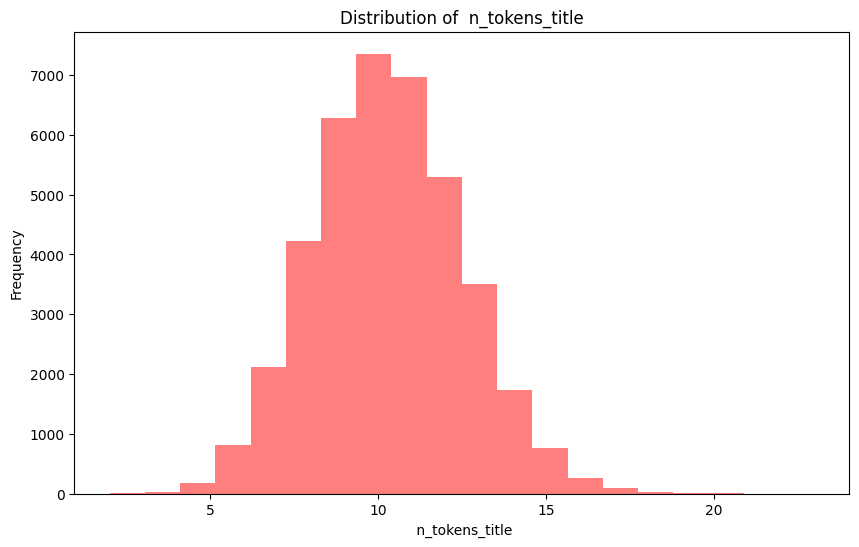

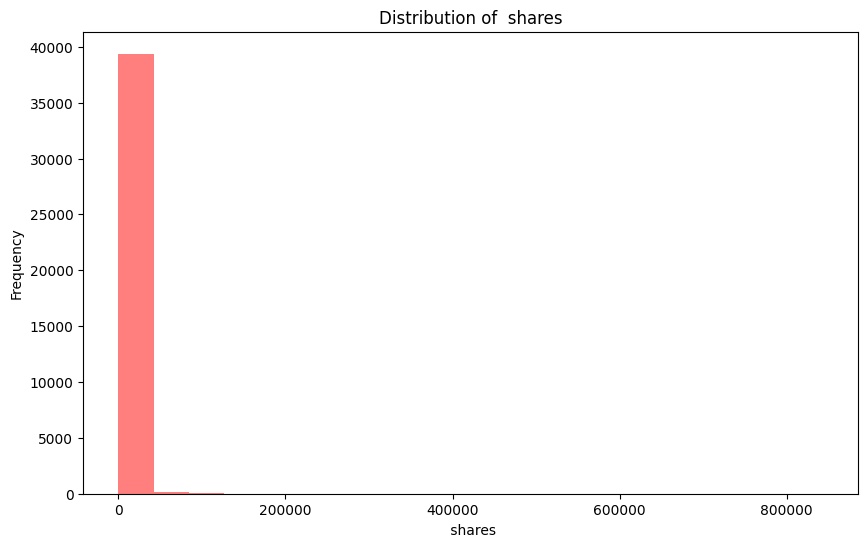

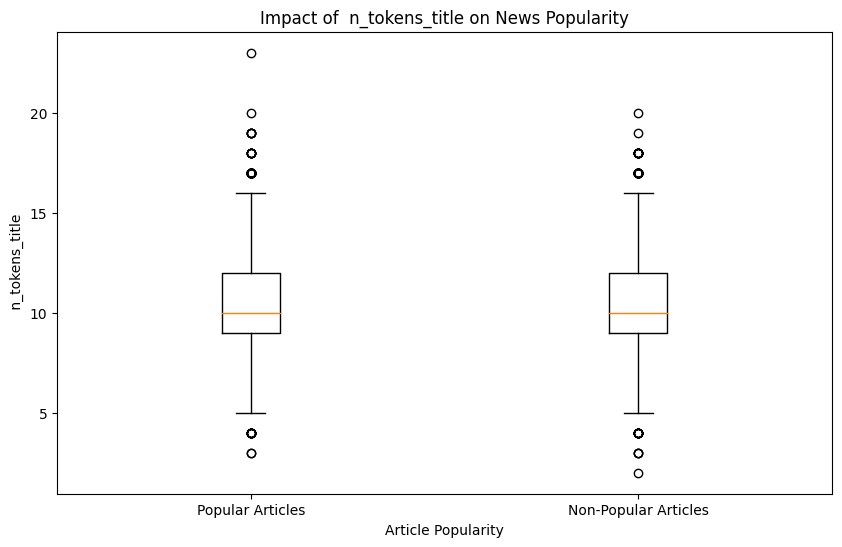

In [ ]:
# Identify key features
key_features = [' n_tokens_title', ' shares']

# Plot histograms to visualize the distribution of key features
for feature in key_features:
    plt.figure(figsize=(10, 6))
    plt.hist(df_spark.select(feature).rdd.flatMap(lambda x: x).collect(), bins=20, alpha=0.5, color='red')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature}')
    plt.show()

# Analyze the impact of key features on news popularity
for feature in key_features[:-1]:  # Exclude 'shares' from analysis
    plt.figure(figsize=(10, 6))
    plt.boxplot([popular_articles.select(feature).rdd.flatMap(lambda x: x).collect(),
                 non_popular_articles.select(feature).rdd.flatMap(lambda x: x).collect()],
                labels=['Popular Articles', 'Non-Popular Articles'])
    plt.xlabel('Article Popularity')
    plt.ylabel(feature)
    plt.title(f'Impact of {feature} on News Popularity')
    plt.show()

In [ ]:
# Create new columns
df_spark = df_spark.withColumn("article_length", lit(None).cast(IntegerType()))
df_spark = df_spark.withColumn("categories", lit(None).cast(IntegerType()))

# Show the DataFrame schema
df_spark.printSchema()

root
 |--  n_tokens_title: double (nullable = true)
 |--  n_tokens_content: double (nullable = true)
 |--  n_unique_tokens: double (nullable = true)
 |--  n_non_stop_words: double (nullable = true)
 |--  n_non_stop_unique_tokens: double (nullable = true)
 |--  num_hrefs: double (nullable = true)
 |--  num_self_hrefs: double (nullable = true)
 |--  num_imgs: double (nullable = true)
 |--  num_videos: double (nullable = true)
 |--  average_token_length: double (nullable = true)
 |--  num_keywords: double (nullable = true)
 |--  data_channel_is_lifestyle: double (nullable = true)
 |--  data_channel_is_entertainment: double (nullable = true)
 |--  data_channel_is_bus: double (nullable = true)
 |--  data_channel_is_socmed: double (nullable = true)
 |--  data_channel_is_tech: double (nullable = true)
 |--  data_channel_is_world: double (nullable = true)
 |--  kw_min_min: double (nullable = true)
 |--  kw_max_min: double (nullable = true)
 |--  kw_avg_min: double (nullable = true)
 |--  kw_mi

In [ ]:
from pyspark.ml.feature import VectorAssembler
# Replace null values with a specific placeholder value
df_spark = df_spark.fillna(-1)  # You can replace -1 with any value you prefer

# Assuming feature_cols is correctly defined and corresponds to column names
feature_cols = list(df_spark.columns)

# Create VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Split the dataset into training and testing sets (80:20 ratio)
train_df, test_df = df_spark.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
# Logistic regression
classifier = DecisionTreeClassifier(featuresCol="features", labelCol="popularity")
pipeline = Pipeline(stages=[assembler, classifier])
model = pipeline.fit(train_df)
# Make predictions on the testing set
predictions = model.transform(test_df)

In [ ]:
# Calculate accuracy, precision, recall, F1 score and AUC-ROC+
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="popularity")

# Accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Accuracy:", accuracy)

# Precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print("Precision:", precision)

# Recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print("Recall:", recall)

# F1 score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("F1 Score:", f1_score)

# AUC-ROC
predictionAndLabels = predictions.select("prediction", "popularity").rdd.map(lambda row: (float(row.prediction), float(row.popularity)))
metrics = BinaryClassificationMetrics(predictionAndLabels)
auc_roc = metrics.areaUnderROC
print("AUC-ROC:", auc_roc)

# Confusion matrix
confusion_matrix = predictions.groupby("popularity").pivot("prediction").count().na.fill(0).orderBy("popularity")
confusion_matrix.show()

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


AUC-ROC: 1.0
+----------+----+----+
|popularity| 0.0| 1.0|
+----------+----+----+
|         0|2141|   0|
|         1|   0|5655|
+----------+----+----+



In [ ]:
# Stop Spark session
spark.stop()